In [2]:
import dash
from dash import html, dcc
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
import numpy as np

In [ ]:
def compute_price_over_km(x, P_mean, consumption, km_per_year=25000, price_inflation=0.02):
    '''
    x : km driven
    P_mean : price distribution mean
    consumption : consumption in [units of energy] per 100 km
    '''
    i = x / km_per_year
    return x * (1 + price_inflation)**i * P_mean * consumption / 100


def price_depreciation(base_price, x, depreciation_rate=0.05, km_per_year=25000):
    i = x / km_per_year
    decay = piecewise_decay(x, base_price)
    cost = base_price * ((1 + depreciation_rate)**i - 1)
    cost[np.where(cost > base_price)] = base_price
    return cost


ev_base_price = 32000  # Example price in euros
cv_base_price = 20000


# EV cost distribution
x_values_ev = np.array([0.0, 0.2, 0.4, 0.6]) # ct/kWh
y_values_ev_public_charge = np.array([0.0, 0.0, 0.85, 0.15]) # Probability Density2
y_values_ev_public_charge = y_values_ev_public_charge / np.sum(y_values_ev_public_charge)  # Normalize to 1

y_values_ev_home_charge = np.array([0., 0.75, 0.2, 0.05]) # Probability Density
y_values_ev_home_charge = y_values_ev_home_charge / np.sum(y_values_ev_home_charge)  # Normalize to 1

# CV cost
x_values_cv = np.array([1.5, 1.6, 1.7]) # €/L
y_values_cv = np.array([0.1, 0.5, 0.4]) # Probability Density

mean_cost_ev = x_values_ev @ y_values_ev_public_charge
print(mean_cost_ev)

mean_cost_ev = x_values_ev @ y_values_ev_home_charge
print(mean_cost_ev)

mean_cost_cv = x_values_cv @ y_values_cv
print(mean_cost_cv)


consumption_ev_optimistic = 17  # kWh per 100 km
consumption_ev_realistic = 21  # kWh per 100 km
consumption_ev_pessimistic = 24  # kWh per 100 km

consumption_cv_optimistic = 5  # L per 100 km
consumption_cv_realistic = 7  # L per 100 km
consumption_cv_pessimistic = 9  # L per 100 km

x = np.linspace(0, 200000, 1000)


# Compute price over km for different consumption scenarios
price_ev_optimistic = compute_price_over_km(x, mean_cost_ev, consumption_ev_optimistic, price_inflation=0.03)
price_ev_realistic = compute_price_over_km(x, mean_cost_ev, consumption_ev_realistic, price_inflation=0.03)
price_ev_pessimistic = compute_price_over_km(x, mean_cost_ev, consumption_ev_pessimistic, price_inflation=0.03)


price_cv_optimistic = compute_price_over_km(x, mean_cost_cv, consumption_cv_optimistic, price_inflation=0.03)
price_cv_realistic = compute_price_over_km(x, mean_cost_cv, consumption_cv_realistic, price_inflation=0.03)
price_cv_pessimistic = compute_price_over_km(x, mean_cost_cv, consumption_cv_pessimistic, price_inflation=0.03)

# Create traces for the plot

depreciation_ev = price_depreciation(ev_base_price, x, depreciation_rate=0.15)
depreciation_cv = price_depreciation(cv_base_price, x, depreciation_rate=0.1)


trace_ev_optimistic = go.Scatter(x=x, y=price_ev_optimistic + depreciation_ev, mode='lines', name='EV [17kWh/100km]')
trace_ev_realistic = go.Scatter(x=x, y=price_ev_realistic + depreciation_ev, mode='lines', name='EV [21kWh/100km]')
trace_ev_pessimistic = go.Scatter(x=x, y=price_ev_pessimistic + depreciation_ev, mode='lines', name='EV [24kWh/100km]')
trace_cv_optimistic = go.Scatter(x=x, y=price_cv_optimistic + depreciation_cv, mode='lines', name='CV [5l/100km]')
trace_cs_realistic = go.Scatter(x=x, y=price_cv_realistic + depreciation_cv, mode='lines', name='CV [7l/100km]')
trace_cs_pessimistic = go.Scatter(x=x, y=price_cv_pessimistic + depreciation_cv, mode='lines', name='CV [9l/100km]')

trace_dep_ev = go.Scatter(x=x, y=depreciation_ev, mode='lines', name='Depreciation EV')
trace_dep_cv = go.Scatter(x=x, y=depreciation_cv, mode='lines', name='Depreciation CV')

# Create the figure
fig = go.Figure(
    data=[
        trace_ev_optimistic,
        trace_ev_realistic,
        trace_ev_pessimistic,
        trace_cv_optimistic,
        trace_cs_realistic,
        trace_cs_pessimistic,
        # trace_dep_ev,
        # trace_dep_cv,
    ]
)

# Update layout
fig.update_layout(title='Cost Over Distance Driven',
                  xaxis_title='Distance Driven (km)',
                  yaxis_title='Cost (€)',
                  legend_title='Scenarios')

# Show the figure
fig.show()

0.43000000000000005
0.26
1.6300000000000001


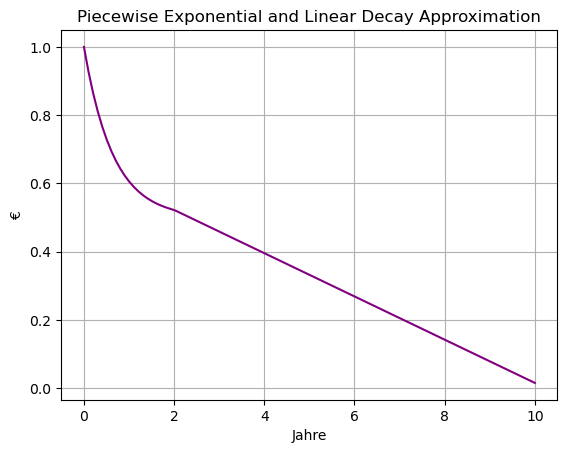

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def piecewise_decay(t, A=30000, k=1.55, slope=-1900, x_transition=2):
    """
    Approximates a piecewise function with exponential decay until x=2 and linear decay after.
    
    Parameters:
    t : array-like
        Time values in years.
    A : float
        Initial value at t=0.
    k : float
        Decay constant for the exponential part.
    slope : float
        Slope of the linear decay part.
    x_transition : float
        The x-value at which the function transitions from exponential to linear decay.
        
    Returns:
    array-like
        Approximated values for each time t.
    """
    # Initialize an array to store the values
    values = np.zeros_like(t)
    
    # Exponential decay for t <= x_transition
    exponential_part = A/2 * np.exp(-k * t[t <= x_transition]) + A/2
    values[t <= x_transition] = exponential_part
    
    # Linear decay for t > x_transition
    linear_start_value = A/2 * np.exp(-k * x_transition) + A/2  # Value at the transition point
    linear_part = linear_start_value + slope * (t[t > x_transition] - x_transition)
    values[t > x_transition] = linear_part
    
    return values / A

# Generate time values
years = np.linspace(0, 10, 100)

# Calculate piecewise values
values = piecewise_decay(years)

# Plot the approximation
plt.plot(years, values, label="Piecewise Decay Approximation", color="purple")
plt.xlabel("Jahre")
plt.ylabel("€")
plt.title("Piecewise Exponential and Linear Decay Approximation")
plt.grid(True)
plt.show()
